# Classification Analysis

*Instructions*
จงทำนายค่าจากข้อมูลต่อไปนี้
ข้อมูลอยู่ใน google drive (เข้าดูด้วย KMITL Account) https://drive.google.com/drive/u/2/folders/15NgSBbLC9iNCf_fRHZHOm3nuwkzv8fcP

ข้อมูลมี 2 ชุด คือ C กับ D

ช้อมูลชุด C
ไฟล์ C-train.csv เป็นชุดสำหรับ training
ไฟล์ C-test.csv เป็นชุดข้อมูลสำหรับ test เพื่อพยากรณ์หาค่า y คือ C_01, C_02, ...., C_10
ช้อมูลชุด D
ไฟล์ D-train.csv เป็นชุดสำหรับ training
ไฟล์ D-test.csv เป็นชุดข้อมูลสำหรับ test เพื่อพยากรณ์หาค่า y คือ D_01, D_02, ...., D_10

จากนั้นให้นำผลลัพธ์ที่ทำนายได้ไปกรอกใน Google Form 
ที่: https://forms.gle/Cdjt4qdizWJozk9r5

การให้คะแนน
ให้คะแนนตามความถูกต้องของการแบ่งประเภท (correct classification)
เนื่องจากมีข้อมูล 2 ชุด ดั้งนั้น จะได้คะแนนที่มากที่สุดจาก C กับ D
กล่าวคือ ถ้าได้คะแนนของ C เป็น 2 คะแนน แต่ ได้คะแนนของ D เป็น 8 คะแนน
งานชุดนี้จะได้ max(2, 8) คือ 8 คะแนน

## Dataset D

In [37]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
df_OG= pd.read_csv('D-train.csv')

In [38]:
df_OG.y.unique()

array(['B', 'A', 'C'], dtype=object)

In [39]:
df = df_OG

In [40]:
print(df.head())
print(df.info())

      x1     x2     x3     x4    x5  y
0   3.29  13.54   9.40  12.62  1.95  B
1 -10.87  24.20  24.09  23.96  0.11  B
2 -20.62  32.28  32.31  33.47 -1.30  B
3   3.01   0.44  19.68  -8.05  2.38  A
4   7.53   2.31   4.71  -0.88  2.25  B
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      190 non-null    float64
 1   x2      190 non-null    float64
 2   x3      190 non-null    float64
 3   x4      190 non-null    float64
 4   x5      190 non-null    float64
 5   y       190 non-null    object 
dtypes: float64(5), object(1)
memory usage: 9.0+ KB
None


**No null value !!**

<AxesSubplot:>

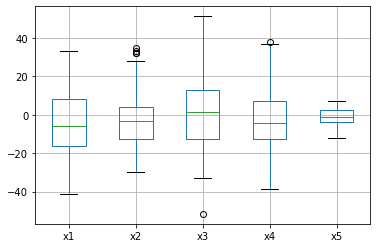

In [41]:
df.boxplot()

In [42]:
X = df[["x1","x2","x3","x4","x5"]]
y = df["y"]

<AxesSubplot:>

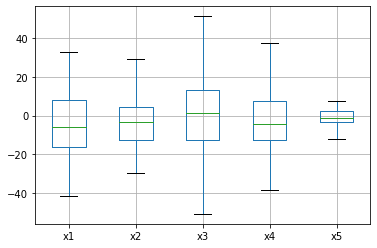

In [43]:
def drop_outlier(x):
    return x[(x < x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25))) & (x > x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)))]
def cap_outlier(x):
    return x.clip(x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)), x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)))
X = X.apply(cap_outlier)
X.boxplot()


**step: 4**
  
  step: 4.1

In [44]:
envs={}
envs["LR"] = LogisticRegression(solver='lbfgs', max_iter=1000)
envs["DT"] = DecisionTreeClassifier()
envs["NB"] = GaussianNB()
envs["KNN (k3)"] = KNeighborsClassifier(n_neighbors=3)
envs["KNN (k5)"] = KNeighborsClassifier(n_neighbors=5)
envs["ANN (h10)"] = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', max_iter=5000)
envs["ANN (h100)"] = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', max_iter=5000)

In [45]:
dfTest_OG = pd.read_csv('D-test.csv')
x_test_og = dfTest_OG[['x1', 'x2', 'x3', 'x4', 'x5']]
x_test_og

,x1,x2,x3,x4,x5
0,13.87,-1.59,-9.22,-1.92,2.49
1,39.41,-10.24,3.14,-24.40,9.37
2,-0.98,-6.98,-12.01,-3.83,-1.44
3,-4.39,-22.38,4.94,-29.28,-1.25
4,-8.66,-5.71,14.59,-10.83,-1.00
5,2.20,9.24,-5.77,13.47,0.30
6,-8.28,-5.53,20.95,-13.24,-0.36
7,-15.23,25.83,20.04,28.76,-1.23
8,-23.17,-18.72,-6.80,-15.12,-6.61
9,13.27,16.44,6.65,14.83,4.18


In [46]:
env_results = {} # for storing results

for env_name in envs.keys():

  acc_list = [] # for storing accuracy in each fold 

  #  step: 4.2
  kf = KFold(n_splits=3)

  for train_index, test_index in kf.split(X):
    #  step: 4.2.1
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #  step: 4.2.2 (n/a)

    #  step: 4.2.3
    model = envs[env_name].fit(X_train, y_train)

    #  step: 4.2.4
    y_pred = model.predict(X_test)

    #  step: 4.2.5
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

  # step: 4.3
  acc_mean = np.mean(acc_list)
  env_results[env_name] = round(acc_mean,5)

In [47]:
print(env_results)

{'LR': 0.83697, 'DT': 0.77397, 'NB': 0.79481, 'KNN (k3)': 0.78943, 'KNN (k5)': 0.78431, 'ANN (h10)': 0.81572, 'ANN (h100)': 0.81572}


**step: 6**


In [48]:
model = envs['LR'].fit(X,y)

**step7**

In [49]:
y_pred = model.predict(x_test_og)
y_pred

array(['A', 'A', 'C', 'C', 'C', 'B', 'C', 'B', 'C', 'B'], dtype=object)